Build and train a CNN model to classify sign language using PyTorch

In [1]:
# mount google drive. data and utils 
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Coursera/Coursera_DeepLearningSpecialization/course4_coding_assignments/W1A2/

Mounted at /gdrive
/gdrive/My Drive/Coursera/Coursera_DeepLearningSpecialization/course4_coding_assignments/W1A2


In [2]:
!ls

C4WK1A2_CNN_application_Keras.ipynb    datasets		test_utils.py
C4WK1A2_CNN_application_PyTorch.ipynb  images		W1A2_CNN_structure.png
cnn_utils.py			       public_tests.py
Convolution_model_Application.ipynb    __pycache__


In [21]:
# pytorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
print("GPU available: {}".format(torch.cuda.is_available()))

# parse data
import h5py
import numpy as np

# for plotting
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

GPU available: True


In [4]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
if torch.cuda.is_available():
  device = 'cuda' 
else:
  device = 'cpu' 

In [6]:
def load_signs_dataset_pytorch(batch_size=64):
  """ Modified based on cnn_utils.load_signs_dataset() """
  # ======= original cnn_utils.py =======
  train_dataset = h5py.File('datasets/train_signs.h5', "r")
  train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
  train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels
  
  test_dataset = h5py.File('datasets/test_signs.h5', "r")
  test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
  test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

  classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
  # train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
  # test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

  print("train x y orig shape: ", train_set_x_orig.shape, train_set_y_orig.shape)

  # ======= Reshape for PyTorch ====== [channels, height, width]
  train_set_x_orig = np.transpose(train_set_x_orig, (0, 3, 1, 2))
  test_set_x_orig = np.transpose(test_set_x_orig, (0, 3, 1, 2))

  train_set_x_tensor = torch.tensor(train_set_x_orig, dtype = torch.float) / 255
  train_set_y_tensor = torch.tensor(train_set_y_orig, dtype = torch.long)

  test_set_x_tensor = torch.tensor(test_set_x_orig, dtype = torch.float) / 255
  test_set_y_tensor = torch.tensor(test_set_y_orig, dtype = torch.long)

  # transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  train_set = torch.utils.data.TensorDataset(train_set_x_tensor, train_set_y_tensor)
  test_set = torch.utils.data.TensorDataset(test_set_x_tensor, test_set_y_tensor)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle = True, num_workers = 0)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle = True, num_workers = 0)
    
  return train_set, test_set, train_loader, test_loader, classes

In [7]:
# load dataset
train_set, test_set, train_loader, test_loader, classes = load_signs_dataset_pytorch()

train x y orig shape:  (1080, 64, 64, 3) (1080,)


In [8]:
print(len(train_set))
index = 5
print(train_set[index][0].shape, train_set[index][1].shape)
print(test_set[index][0].shape, test_set[index][1].shape)

1080
torch.Size([3, 64, 64]) torch.Size([])
torch.Size([3, 64, 64]) torch.Size([])


y: 4


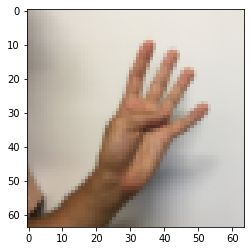

In [9]:
# imshow needs dimensions to be [H, W, C]
image = train_set[index][0].numpy().transpose([1, 2, 0])
plt.imshow(image)
print("y:", train_set[index][1].numpy()  )

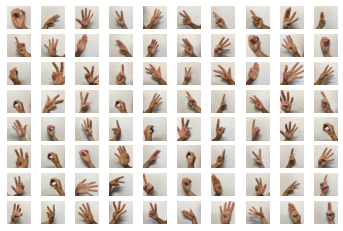

In [10]:
figure = plt.figure()
num_of_images = 80 

for idx in range(1, num_of_images + 1):
    plt.subplot(8, 10, idx)
    plt.axis('off')
    plt.imshow(train_set[idx][0].numpy().transpose([1, 2, 0]))

In [11]:
# cnn_model = nn.Sequential(
#     nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=1, padding=1),
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(kernel_size=8, stride=8, padding=1),
#     nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(inplace=True),
#     nn.MaxPool2d(kernel_size=4, stride=4, padding=1),
#     nn.Flatten(),
#     nn.Linear()
# ).to(device)

## Build CNN Model

`CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> DENSE`

- Conv2D: 4 * 4 filter * 8 + padding = "same"
- ReLU
- MaxPool2D: 8 * 8 filter + 8 * 8 stride + padding = "same"
- Conv2D: 2 * 2 filter * 16 + stride = 1 + padding = "same"
- ReLU
- MaxPool2D: 4 * 4 filter + 4 * 4 stride + padding = "same"
- Flatten
- Full-connected (Dense): 6 neurons + softmax

CNN Structure (drawn by https://alexlenail.me/NN-SVG/AlexNet.html)

<img src="https://drive.google.com/uc?id=1xiQslSH5VMb-1ng1SNjLvBCgvtwaX_6O">

In [12]:
class Model(nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=1, padding="same")
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=2, stride=1, padding="same")
    self.maxpool1 = nn.MaxPool2d(kernel_size=8, stride=8, padding=1)
    self.maxpool2 = nn.MaxPool2d(kernel_size=4, stride=4, padding=1)
    self.fc1 = nn.Linear(in_features=2 * 2 * 16, out_features=6)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.maxpool1(x)
    x = F.relu(self.conv2(x))
    x = self.maxpool2(x)
    x = x.view(-1, 2 * 2 * 16)
    x = self.fc1(x)
    return x

cnn_model = Model()
cnn_model.to(device)

Model(
  (conv1): Conv2d(3, 8, kernel_size=(4, 4), stride=(1, 1), padding=same)
  (conv2): Conv2d(8, 16, kernel_size=(2, 2), stride=(1, 1), padding=same)
  (maxpool1): MaxPool2d(kernel_size=8, stride=8, padding=1, dilation=1, ceil_mode=False)
  (maxpool2): MaxPool2d(kernel_size=4, stride=4, padding=1, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=6, bias=True)
)

In [13]:
from torchinfo import summary
summary(cnn_model, input_size=(128, 3, 64, 64))

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [128, 6]                  --
├─Conv2d: 1-1                            [128, 8, 64, 64]          392
├─MaxPool2d: 1-2                         [128, 8, 8, 8]            --
├─Conv2d: 1-3                            [128, 16, 8, 8]           528
├─MaxPool2d: 1-4                         [128, 16, 2, 2]           --
├─Linear: 1-5                            [128, 6]                  390
Total params: 1,310
Trainable params: 1,310
Non-trainable params: 0
Total mult-adds (M): 209.90
Input size (MB): 6.29
Forward/backward pass size (MB): 34.61
Params size (MB): 0.01
Estimated Total Size (MB): 40.91

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters())

In [15]:
def train(model, train_loader, test_loader, epochs = 100, interval=10):
  history = {
      "loss_train": [],
      "loss_val": [],
      "acc_train": [],
      "acc_val": [],
  }
  train_size = len(train_loader.dataset)
  test_size = len(test_loader.dataset)

  for epoch in range(epochs):
    train_loss = 0.0
    val_loss = 0.0
    correct = 0
    # iterate over mini-batches
    for i, data in enumerate(train_loader, 0):
      inputs, labels = data
      inputs = inputs.to(device) # move data to gpu
      labels = labels.to(device)
      optimizer.zero_grad() # clear gradients
      outputs = model(inputs) # forward pass
      loss = criterion(outputs, labels) # compute loss
      loss.backward() # backward pass
      optimizer.step() # update parameters
      train_loss += loss.item()
      _, predicted = torch.max(outputs.data, dim=1)
      correct += (predicted == labels).sum().item()
    train_loss = train_loss / train_size
    train_acc = correct / train_size

    # evaluation
    correct = 0
    with torch.no_grad():
      for data in test_loader: 
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels) # compute loss
        val_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim=1)
        correct += (predicted == labels).sum().item()
      val_acc = correct / test_size
      val_loss = val_loss / test_size
      
    # stats of each epoch
    history["loss_train"].append(train_loss)
    history["loss_val"].append(val_loss)
    history["acc_train"].append(train_acc)
    history["acc_val"].append(val_acc)
    if (epoch+1) % interval == 0:
      print(f'Epoch: {epoch+1}/{epochs}, train loss: {train_loss:.3f}, train_acc: {train_acc:.3f}, val_loss: {val_loss:.3f}, val_acc: {val_acc:.3f}')
  
  print('Training Done')
  return history

In [24]:
history = train(cnn_model, train_loader, test_loader, epochs=100, interval=1)

Epoch: 1/100, train loss: 0.007, train_acc: 0.861, val_loss: 0.009, val_acc: 0.817
Epoch: 2/100, train loss: 0.006, train_acc: 0.879, val_loss: 0.009, val_acc: 0.800
Epoch: 3/100, train loss: 0.006, train_acc: 0.877, val_loss: 0.009, val_acc: 0.800
Epoch: 4/100, train loss: 0.006, train_acc: 0.874, val_loss: 0.009, val_acc: 0.808
Epoch: 5/100, train loss: 0.006, train_acc: 0.886, val_loss: 0.009, val_acc: 0.817
Epoch: 6/100, train loss: 0.006, train_acc: 0.882, val_loss: 0.009, val_acc: 0.817
Epoch: 7/100, train loss: 0.006, train_acc: 0.880, val_loss: 0.008, val_acc: 0.825
Epoch: 8/100, train loss: 0.006, train_acc: 0.886, val_loss: 0.009, val_acc: 0.825
Epoch: 9/100, train loss: 0.006, train_acc: 0.881, val_loss: 0.008, val_acc: 0.825
Epoch: 10/100, train loss: 0.006, train_acc: 0.887, val_loss: 0.008, val_acc: 0.842
Epoch: 11/100, train loss: 0.006, train_acc: 0.881, val_loss: 0.008, val_acc: 0.817
Epoch: 12/100, train loss: 0.006, train_acc: 0.883, val_loss: 0.008, val_acc: 0.833
E

In [25]:
history

{'loss_train': [0.006630138556162516,
  0.006463124741006781,
  0.006441973591292346,
  0.006215921568649786,
  0.006204983702412358,
  0.006273600707451503,
  0.006080484362664046,
  0.0060770276519987315,
  0.006058694311866054,
  0.005967729014379007,
  0.005973128312163883,
  0.006049076909268344,
  0.005881339904886705,
  0.006006352603435516,
  0.005890325567236653,
  0.005821635201573372,
  0.00583807654954769,
  0.005650237575173378,
  0.005732006772800728,
  0.005671682705481847,
  0.005886850630243619,
  0.005680122971534729,
  0.005796674583797102,
  0.005629493185767421,
  0.005579234466508582,
  0.0055023510147024085,
  0.005507308837992174,
  0.005562377072594784,
  0.005554009504892208,
  0.005343229640965109,
  0.005315916957678618,
  0.005413428211101779,
  0.005379629797405667,
  0.0052624712387720745,
  0.0052510897042574705,
  0.005172973747054736,
  0.005023588074578179,
  0.005169086558399377,
  0.00492495157652431,
  0.005118950594354559,
  0.005020509108349129,


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

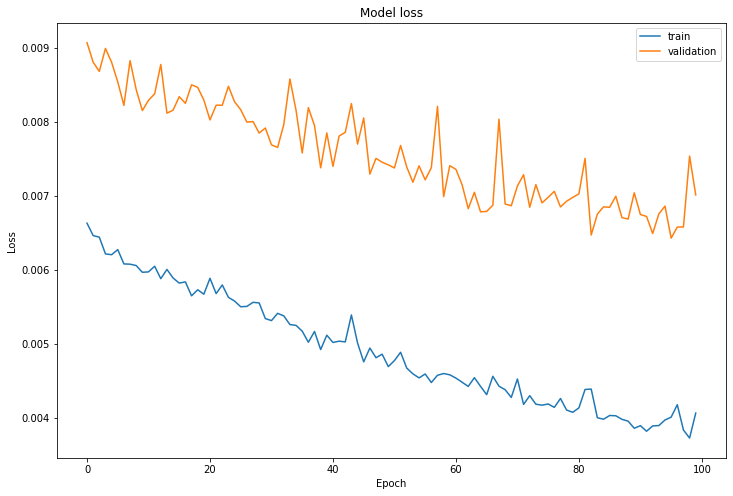

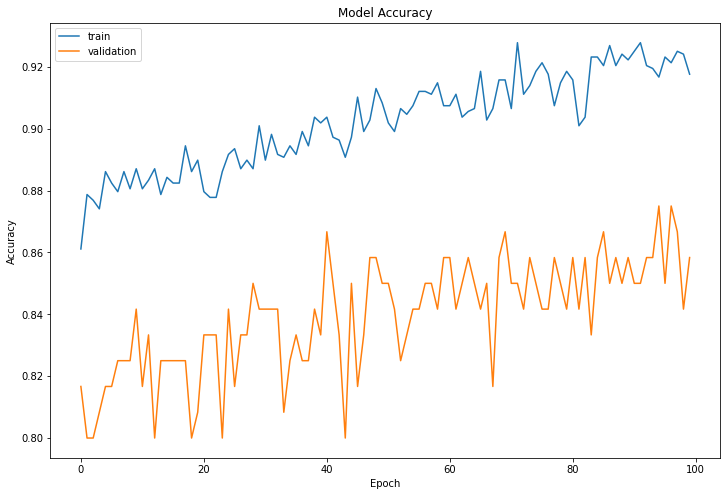

In [27]:
df_loss_acc = pd.DataFrame(history)
df_loss = df_loss_acc[['loss_train', 'loss_val']]
df_loss.rename(columns={'loss_train':'train','loss_val':'validation'},inplace=True)
df_acc= df_loss_acc[['acc_train','acc_val']]
df_acc.rename(columns={'acc_train':'train','acc_val':'validation'},inplace=True)

df_loss.plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

In [ ]:
# the plot looks weird...